In this notebook, we are going to build a computer vision model for identifying lane lines in road images.
+ Camera calibration
+ Distortion correction
+ Extracting lane line pixels using color thresholding
+ Perspective transformation
+ Calculating lane curvature
+ Producing output images and videos with highlighted lane lines

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
from camera import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Camera calibration

In [48]:
camera_calibrate()

Calibration Done.


## A quick test on one image

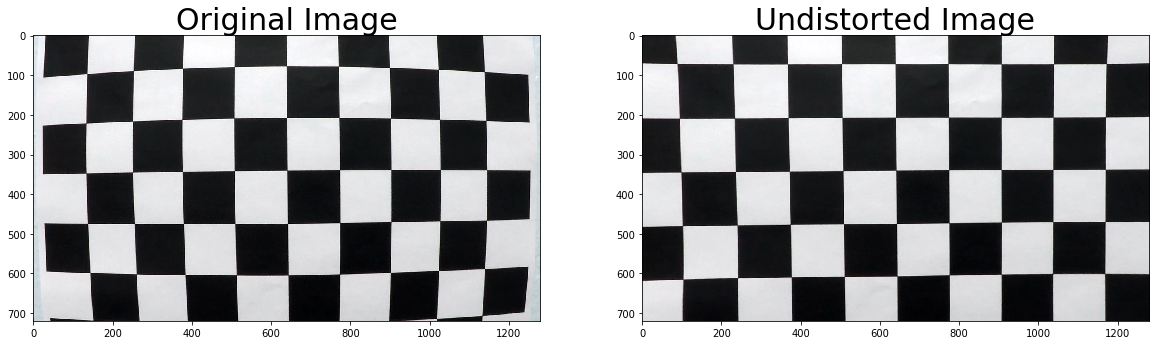

In [49]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
dst = correctCameraDistortion(img)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Test the distortion correction pipeline

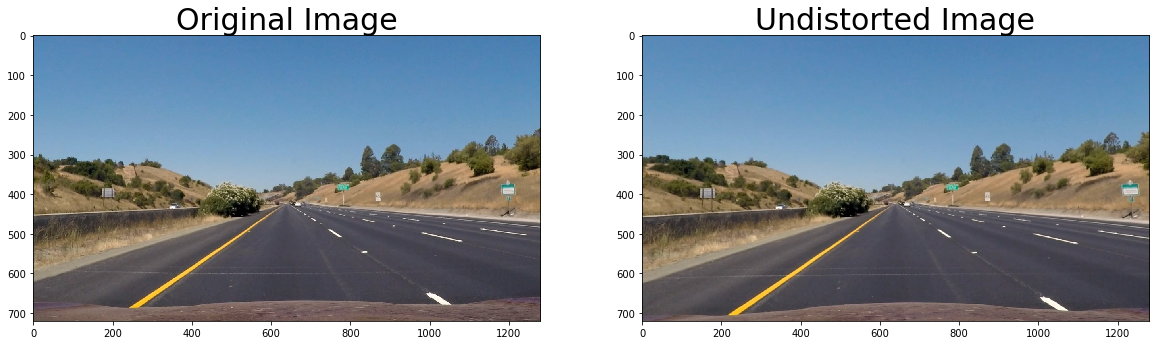

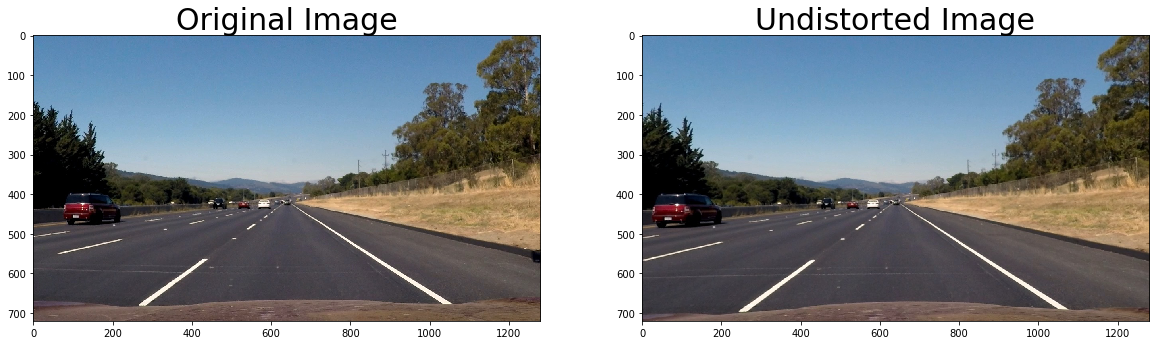

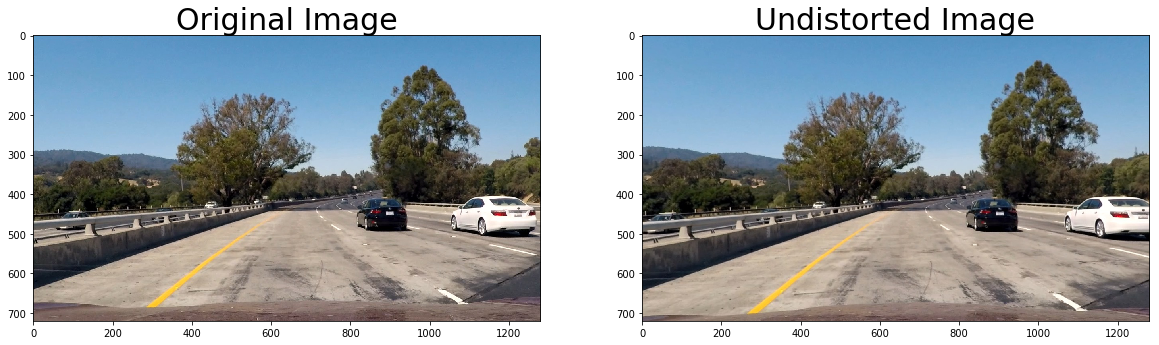

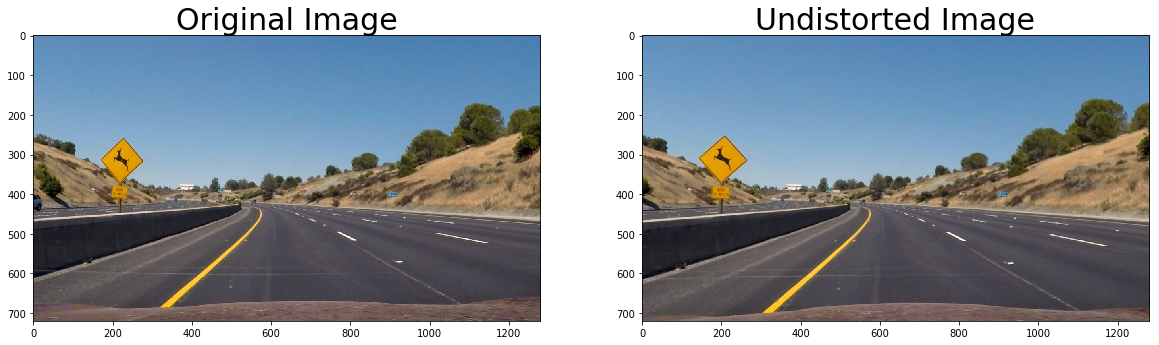

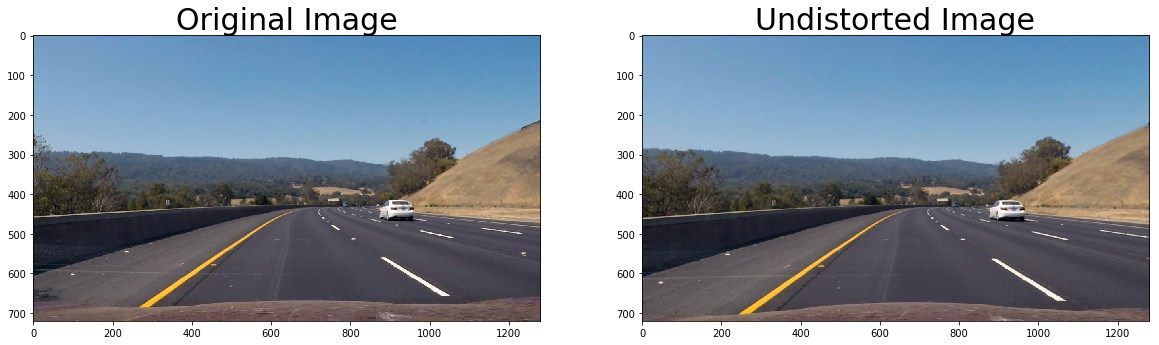

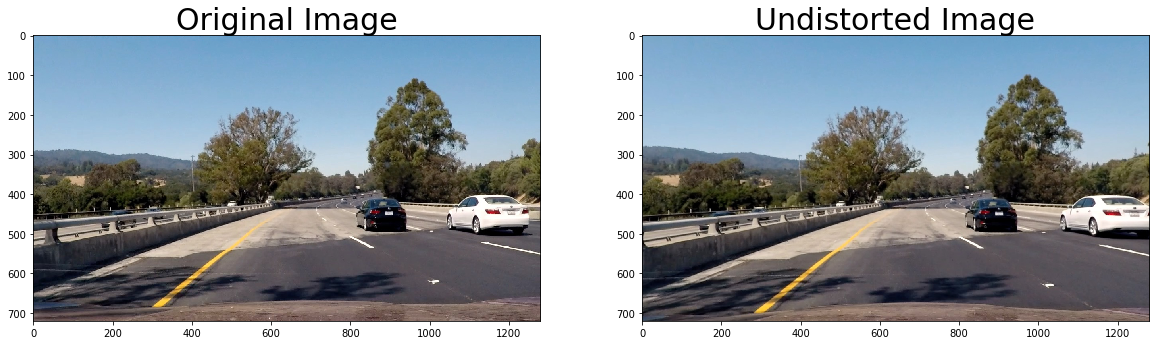

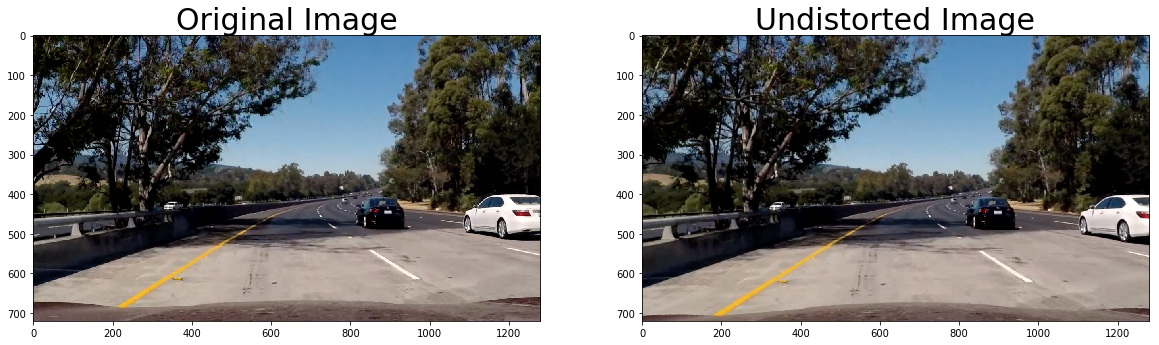

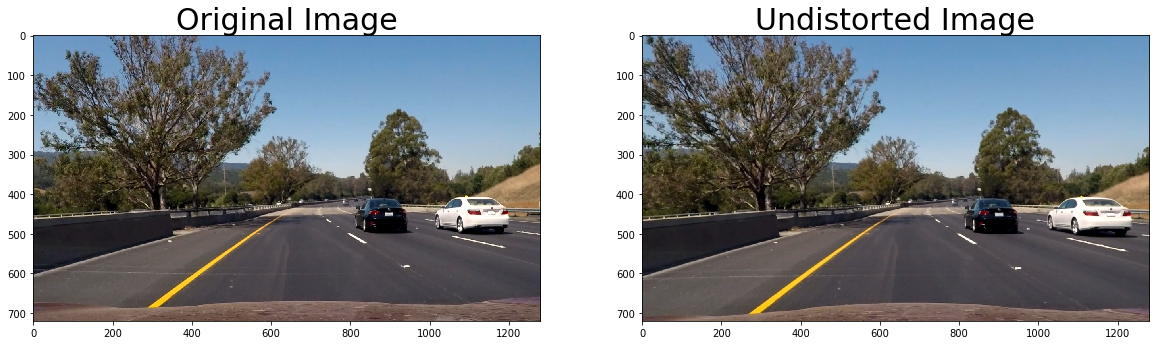

In [46]:
images = glob.glob('test_images/*.jpg')
for name in images:
    image = mpimg.imread(name)
    dst = correctCameraDistortion(image)
    if not os.path.exists('test_images_output'):
        os.makedirs('test_images_output')
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    cv2.imwrite('test_images_output/'+ name.split('/')[1], dst)

In [31]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x',  sobel_kernel=3,thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >=  thresh[0]) & (scaled_sobel <=  thresh[1])] = 1

    # Return the result
    return binary_output

In [32]:
def thresholdImageToBinary(image):
    ksize=3
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 512))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1)) & ((dir_binary == 1))] = 1
    return combined

In [19]:
# Edit this function to create your own pipeline.
def color_gradient_pipeline(img, s_thresh=(200, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    binary_output =  np.zeros_like(s_binary)
    #binary_output[(s_binary==1) & (sxbinary==1)] = 1
    binary_output[((s_binary == 1) | (sxbinary == 1))] = 1
    return binary_output
    #return color_binary

test_images/straight_lines1.jpg
(720, 1280)


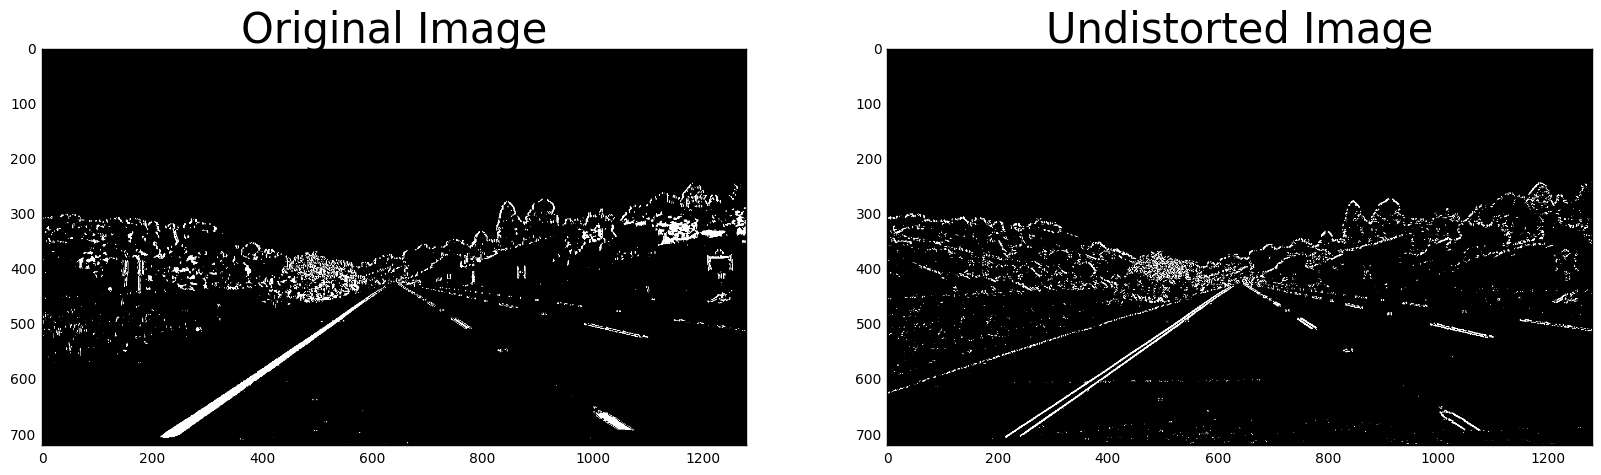

In [78]:
#
# NOTE ---- CONVERT FROM RGB TO HSV and just use one channel as "GRAYSCALE"
#  move grayscale conversion out
#  then we can use each function for grayscale, or h, or s, or v

raw_images = ['straight_lines1.jpg']#,'straight_lines1.jpg','straight_lines2.jpg','test1.jpg','test2.jpg','test3.jpg','test4.jpg','test5.jpg','test6.jpg']
for image_name in raw_images:
    file_name='test_images/'+image_name
    print(file_name)
    image = mpimg.imread(file_name)
#     image = cv2.imread(file_name)
#     dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    dst = correctCameraDistortion(image)
    
    hsl = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsl[:,:,1]
    s_channel = hsl[:,:,2]

    
    #hls_binary = hls_select(dst, thresh=(200, 255))
    

    colorimg = color_gradient_pipeline(dst, (120, 255), (30, 100))
    print(colorimg.shape)
    #colorimg = color_gradient_pipeline(dst)
    
    #dst = transformColor(dst)
    # Convert to grayscale
    gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)

    dst = thresholdImageToBinary(gray)
    
    betterimg = np.zeros_like(dst)
    betterimg[((dst == 1) | (colorimg == 1))] = 1

    
    #cv2.imwrite('test_images_output/'+image_name,dst)
#     mpimg.imsave('test_images_output/binary'+image_name,dst)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.imshow(colorimg,cmap='gray')
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst,cmap='gray')
    ax2.set_title('Undistorted Image', fontsize=30)

## Project the Image into a Birds-eye view

(720, 1280, 3)


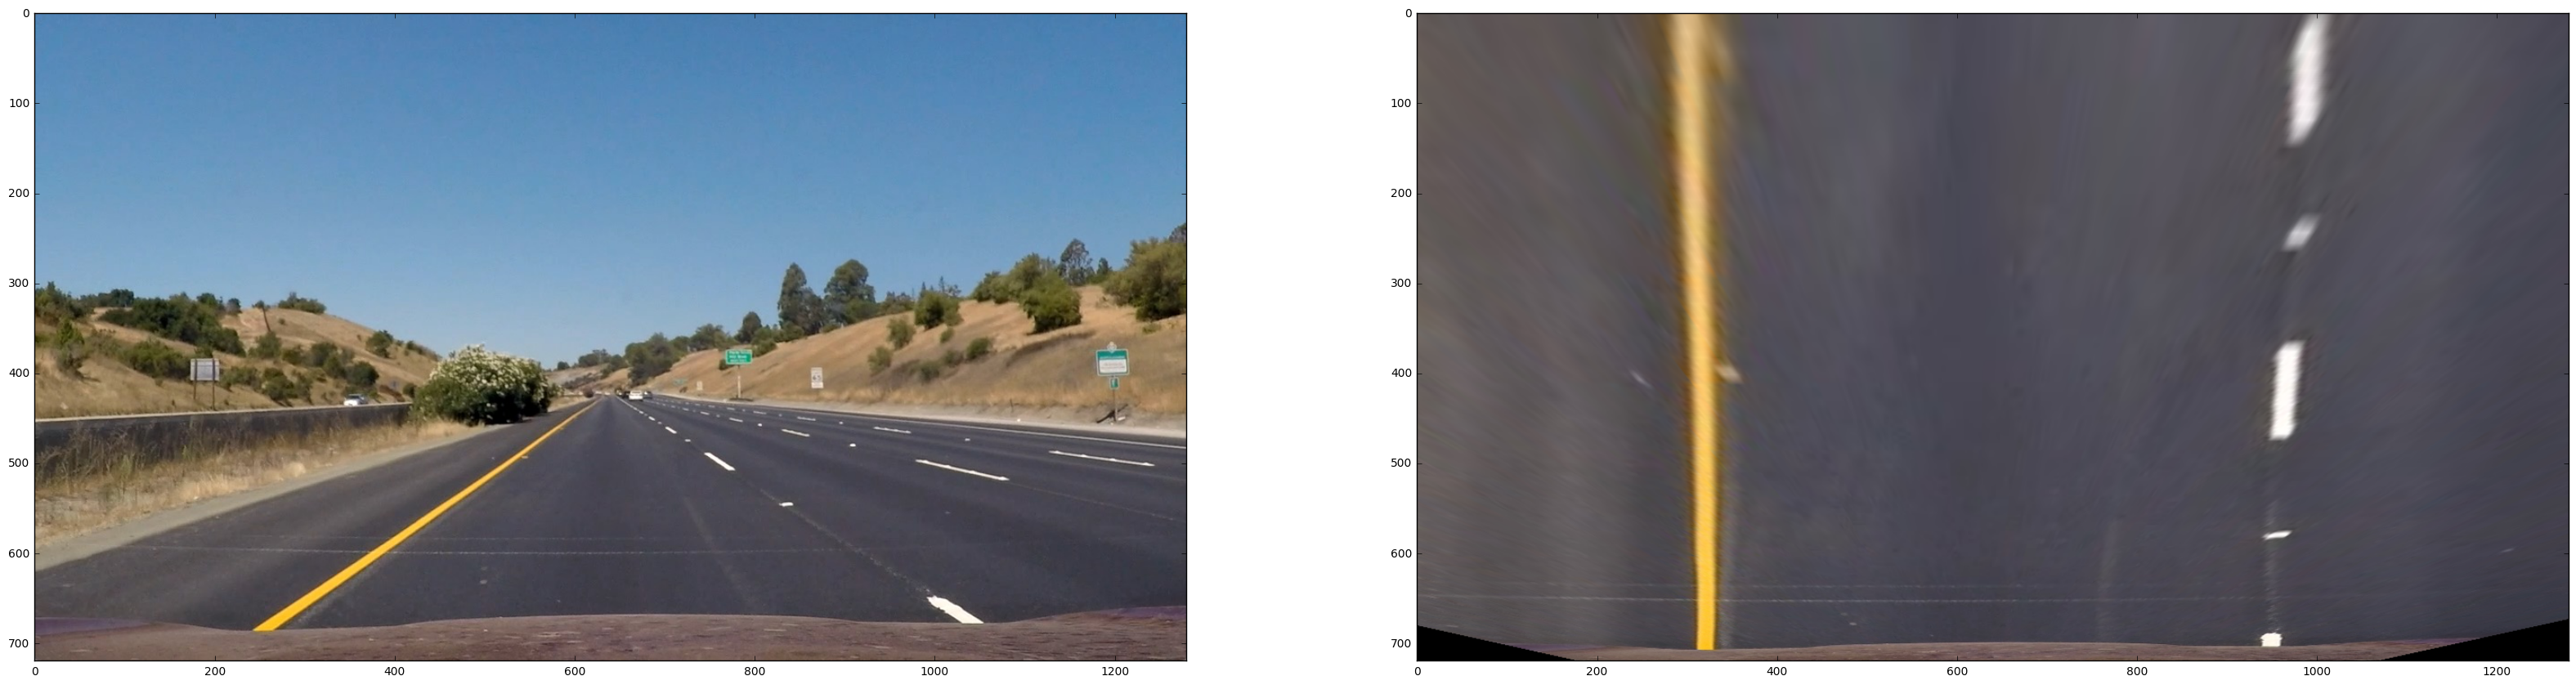

In [79]:
# Takes an image, object points, and image points
# performs the camera calibration, image distortion correction and
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                       imgpoints,
                                                       gray.shape[::-1],
                                                       None,
                                                       None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


# img = cv2.imread('camera_cal/calibration3.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# # Find the chessboard corners
# ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

# img_size = (img.shape[1], img.shape[0])
# offset = 500

# # For source points I'm grabbing the outer four detected corners
# src = np.float32([corners[0], corners[nx - 1], corners[-1], corners[-nx]])
# # For destination points, I'm arbitrarily choosing some points to be
# # a nice fit for displaying our warped result
# dst = np.float32([[offset, offset], [img_size[0] - offset, offset],
#                   [img_size[0] - offset, img_size[1] - offset],
#                   [offset, img_size[1] - offset]])
# # Given src and dst points, calculate the perspective transform matrix
# M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
# warped = cv2.warpPerspective(img, M, img_size)

fname = 'test_images/straight_lines1.jpg'
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (image.shape[1], image.shape[0])
binary_warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
print(binary_warped.shape)
f, axes = plt.subplots(1, 2, figsize=(40, 20))
axes[0].imshow(img)
axes[1].imshow(binary_warped)

plt.show()

In [71]:
def imagePipeline(file_name):
    image = cv2.imread(file_name)
    dst = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dst = correctCameraDistortion(dst)
    colorimg = color_gradient_pipeline(dst, (120, 254), (30, 100))
    return colorimg


def projectImageToBird(image):
    src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
    dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (image.shape[1], image.shape[0])
    binary_warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped


def projectBirdToImage(image):
    src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
    dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (image.shape[1], image.shape[0])
    binary_warped = cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped

test_images/straight_lines1.jpg
image
(720, 1280)


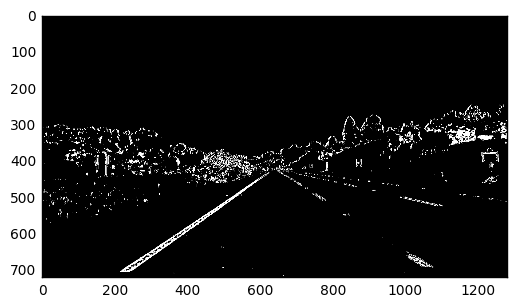

warped


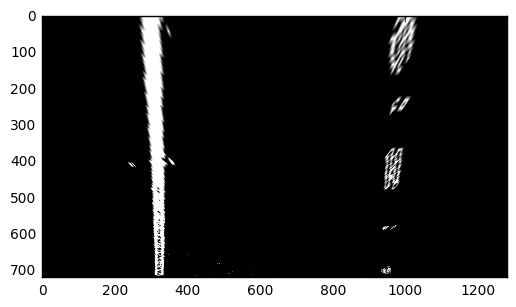

In [80]:
raw_images = ['straight_lines1.jpg']
for image_name in raw_images:
    file_name='test_images/'+image_name
    print(file_name)
    image = imagePipeline(file_name)
    warped=projectImageToBird(image)
    print('image')
    print(warped.shape)
    plt.imshow(image, cmap='gray')
    plt.show()
    print('warped')
    plt.imshow(warped, cmap='gray')
    plt.show()

### Detect lane pixels and fit to find the lane boundary

In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read in a thresholded image
img = mpimg.imread('test_images/straight_lines1.jpg')

#img = mpimg.imread('test_images/test2.jpg')

orig_img = img = correctCameraDistortion(img)
color_warp=projectImageToBird(orig_img)


img = color_gradient_pipeline(img, (120, 254), (30, 100))
#image = imagePipeline(file_name)
warped=projectImageToBird(img)
binary_warped = np.uint8(warped*255)
print(binary_warped.shape)

(720, 1280)


In [61]:
print(warped.shape)

(720, 1280)


(720, 0)

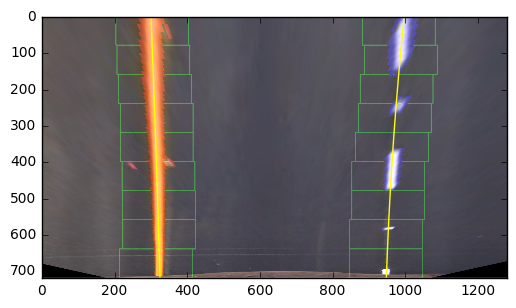

In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# plt.plot(histogram)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


result = cv2.addWeighted(color_warp, 1, out_img, 0.3, 0, dtype=0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [70]:
# print(out_img[0])
print(color_warp[0])

[[98 90 88]
 [97 90 88]
 [97 89 87]
 ..., 
 [72 70 83]
 [72 70 83]
 [72 70 83]]


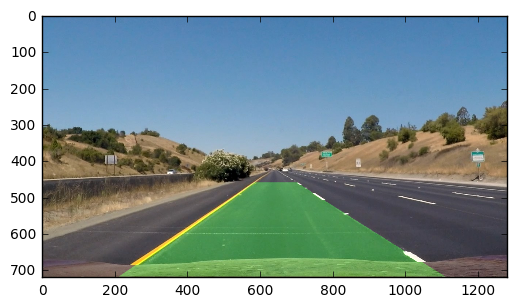

array([[[174, 191, 209],
        [133, 154, 175],
        [118, 144, 171],
        ..., 
        [ 32,  72,  98],
        [  6,  41,  61],
        [ 12,  45,  62]],

       [[131, 152, 173],
        [117, 141, 165],
        [100, 127, 157],
        ..., 
        [ 75, 119, 148],
        [ 47,  85, 108],
        [  2,  37,  57]],

       [[116, 143, 170],
        [101, 130, 160],
        [ 91, 124, 159],
        ..., 
        [ 82, 128, 162],
        [ 76, 120, 149],
        [ 33,  75, 100]],

       ..., 
       [[128, 117, 115],
        [100,  89,  87],
        [ 95,  81,  80],
        ..., 
        [ 85,  70,  67],
        [101,  85,  85],
        [133, 117, 117]],

       [[147, 135, 135],
        [121, 110, 108],
        [102,  91,  89],
        ..., 
        [ 91,  76,  73],
        [125, 109, 109],
        [149, 135, 134]],

       [[189, 177, 177],
        [144, 132, 132],
        [129, 118, 116],
        ..., 
        [127, 112, 109],
        [146, 132, 131],
        [191, 177,

In [74]:
def drawOutput(orig,warped,left_fitx,right_fitx,ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp=projectBirdToImage(color_warp)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
#newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
    result = cv2.addWeighted(orig, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.show()
    return result

origin_img = img

drawOutput(origin_img, warped, left_fitx, right_fitx, ploty)

In [76]:
print(warped.shape)
print(color_warp.shape)

(720, 1280)
(720, 1280, 3)


In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [81]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML